# Group Project 2

### Alex Hausser, Devin Hayes, Galen Sieck, Minh Nguyen, Vivek Nair

## Imports

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve

## Initial Conditions

In [34]:
a, b, n = 0, 5, 1000

x_interp = np.linspace(a, b, n+1)[1:-1]

# 1st Mode
v0s = np.zeros(n-1)
u0s_1st = np.sin(np.pi/5*x_interp)
U0_1st = np.concatenate((u0s_1st, v0s))

# 2nd Mode
u0s_2nd = np.sin(2*np.pi/5*x_interp)
U0_2nd = np.concatenate((u0s_2nd, v0s))

# 3rd Mode
u0s_2nd = np.sin(3*np.pi/5*x_interp)
U0_3rd = np.concatenate((u0s_2nd, v0s))

## Analytical Solution

In [35]:
def analytical(x, t, E, rho):
    c = np.sqrt(E/rho)
    u_e = np.sin((np.pi/5)*x)*np.cos((np.pi/5)*c*t*(7/4))
    return u_e

## Trapezoidal Method

In [39]:
def trapIVP0(E, rho, dt, n, U0):
    # Define dx
    dx = (b-a) / n
    
    ## Define A matrix
    ind = np.arange(0, 2*n-2, 1)
    ones = np.ones(n-1)

    ind_top_half_rows = ind[0:n-1]
    ind_top_half_cols = ind[n-1:]
    ind_bot_half_rows = ind[n-1:]
    ind_bot_half_cols = ind[0:n-1]

    # Add -2 diagonal
    neg2s = -2*ones
    A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add bottom 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top of matrix diagonal
    coef = rho*dx**2/E
    coefs = coef*ones
    A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Multiply A by the coefficient outside the matrix
    A = A*(E/(rho*dx**2))
    
    # Define I matrix
    I = np.eye(2*n-2)
    
    # Define timesteps
    t_step = int(T/dt) + 1
    times = np.linspace(0, T, t_step)
    
    # Define interpolation points
    x_interp = np.linspace(a, b, n+1)
    
    # Define interpolation points removing the boundaries
    x_interp_cut = x_interp[1:-1]
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    # Define left hand side of system
    LHS = I - (dt/2)*A
    
    # Step through time and solve for u_k to build u-vector
    for i in range(len(times)-1):
        RHS = U[i] + (dt/2) * (A @ U[i])
        U[i+1] = spsolve(LHS, RHS)
    
    # Cut U to only give displacements
    U = U[: , 0:n-1]
    
    # Get U Analytical
    U_e = []
    for time in range(len(times)):
        U_e.append(analytical(x_interp_cut, time, E, rho))
    
    return U, times, x_interp_cut, U_e

## Forward Euler

In [40]:
# Zero Forcing Function
def FEIVP0(E, rho, dt, n, U0):
    # Define dx
    dx = (b-a) / n
    
    ## Define A matrix
    ind = np.arange(0, 2*n-2, 1)
    ones = np.ones(n-1)

    ind_top_half_rows = ind[0:n-1]
    ind_top_half_cols = ind[n-1:]
    ind_bot_half_rows = ind[n-1:]
    ind_bot_half_cols = ind[0:n-1]

    # Add -2 diagonal
    neg2s = -2*ones
    A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add bottom 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top of matrix diagonal
    coef = rho*dx**2/E
    coefs = coef*ones
    A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Multiply A by the coefficient outside the matrix
    A = A*(E/(rho*dx**2))
    
    # Define I matrix
    I = np.eye(2*n-2)
    
    # Define timesteps
    t_step = int(T/dt) + 1
    times = np.linspace(0, T, t_step)
    
    # Define interpolation points
    x_interp = np.linspace(a, b, n+1)
    
    # Define interpolation points removing the boundaries
    x_interp_cut = x_interp[1:-1]
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    # Define left hand side of system
    LHS = I
    
    # Step through time and solve for u_k to build u-vector
    for i in range(len(times)-1):
        RHS = U[i] + (dt) * (A @ U[i])
        U[i+1] = spsolve(LHS, RHS)
    
    # Cut U to only give displacements
    U = U[: , 0:n-1]
    
    return U, times, x_interp_cut

## Numerical vs. Analytical

In [41]:
T = 20
# All Displacements at each time step
U1, times, x_int, U1e = trapIVP0(70, 2700, 0.01, 1000, U0_1st) 

C:\Anaconda\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [42]:
# Trap Displacements at different times
U1_t0 = U1[0]
U1_t5 = U1[int(1*(len(times)-1)/4)]
U1_t10 = U1[int((len(times)-1)/2)]
U1_t15 = U1[int(3*(len(times)-1)/4)]
U1_t20 = U1[-1]

# Analytical Displacements
U1e_t0 = U1e[0]
U1e_t5 = U1e[int(1*(len(times)-1)/4)]
U1e_t10 = U1e[int((len(times)-1)/2)]
U1e_t15 = U1e[int(3*(len(times)-1)/4)]
U1e_t20 = U1e[-1]

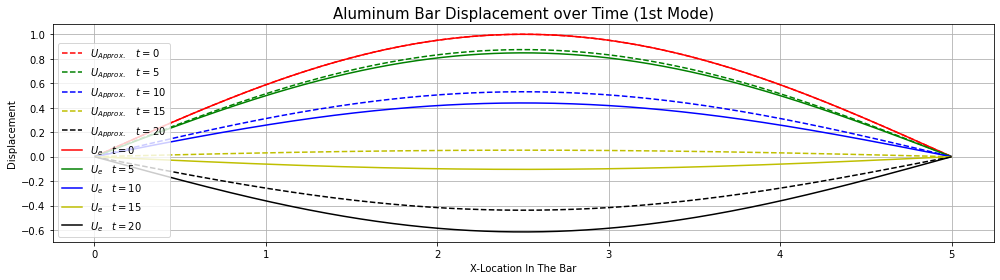

In [45]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 4), tight_layout=True)
ax1 = fig.add_subplot(111)
ax1.plot(x_int, U1_t0, 'r--', label=r'$U_{Approx.} \quad t=0$')
ax1.plot(x_int, U1_t5, 'g--', label=r'$U_{Approx.} \quad t=5$')
ax1.plot(x_int, U1_t10, 'b--', label=r'$U_{Approx.} \quad t=10$')
ax1.plot(x_int, U1_t15, 'y--', label=r'$U_{Approx.} \quad t=15$')
ax1.plot(x_int, U1_t20, 'k--', label=r'$U_{Approx.} \quad t=20$')
ax1.plot(x_int, U1e_t0, 'r', label=r'$U_e \quad t=0$')
ax1.plot(x_int, U1e_t5, 'g', label=r'$U_e \quad t=5$')
ax1.plot(x_int, U1e_t10, 'b', label=r'$U_e \quad t=10$')
ax1.plot(x_int, U1e_t15, 'y', label=r'$U_e \quad t=15$')
ax1.plot(x_int, U1e_t20, 'k', label=r'$U_e \quad t=20$')
ax1.set_xlabel('X-Location In The Bar')
ax1.set_ylabel('Displacement')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.grid()
ax1.set_title('Aluminum Bar Displacement over Time (1st Mode)', size=15) # Trapezoidal Method (Al Alloy)
ax1.legend(loc='lower left');

## Chaning Initial Conditions

In [46]:
U2, times, x_int, U2e = trapIVP0(70, 2700, 0.01, 1000, U0_2nd) 
U3, times, x_int, U3e = trapIVP0(70, 2700, 0.01, 1000, U0_3rd) 

C:\Anaconda\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [47]:
# Trap Displacements at different times
U2_t0 = U2[0]
U2_t5 = U2[int(1*(len(times)-1)/4)]
U2_t10 = U2[int((len(times)-1)/2)]
U2_t15 = U2[int(3*(len(times)-1)/4)]
U2_t20 = U2[-1]

# Trap Displacements at different times
U3_t0 = U3[0]
U3_t5 = U3[int(1*(len(times)-1)/4)]
U3_t10 = U3[int((len(times)-1)/2)]
U3_t15 = U3[int(3*(len(times)-1)/4)]
U3_t20 = U3[-1]

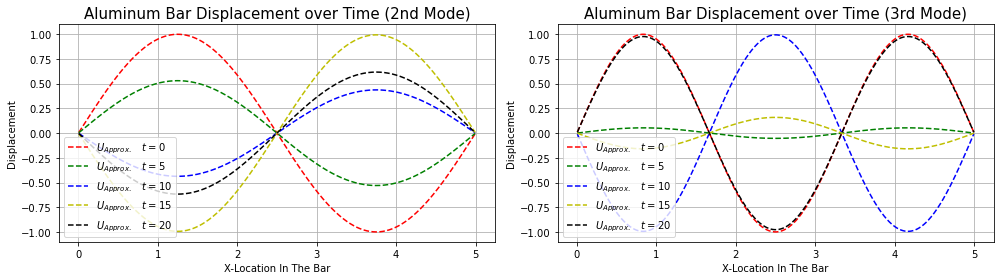

In [50]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 4), tight_layout=True)
ax1 = fig.add_subplot(121)
ax1.plot(x_int, U2_t0, 'r--', label=r'$U_{Approx.} \quad t=0$')
ax1.plot(x_int, U2_t5, 'g--', label=r'$U_{Approx.} \quad t=5$')
ax1.plot(x_int, U2_t10, 'b--', label=r'$U_{Approx.} \quad t=10$')
ax1.plot(x_int, U2_t15, 'y--', label=r'$U_{Approx.} \quad t=15$')
ax1.plot(x_int, U2_t20, 'k--', label=r'$U_{Approx.} \quad t=20$')
ax1.set_xlabel('X-Location In The Bar')
ax1.set_ylabel('Displacement')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.grid()
ax1.set_title('Aluminum Bar Displacement over Time (2nd Mode)', size=15) # Trapezoidal Method (Al Alloy)
ax1.legend(loc='lower left');

ax2 = fig.add_subplot(122)
ax2.plot(x_int, U3_t0, 'r--', label=r'$U_{Approx.} \quad t=0$')
ax2.plot(x_int, U3_t5, 'g--', label=r'$U_{Approx.} \quad t=5$')
ax2.plot(x_int, U3_t10, 'b--', label=r'$U_{Approx.} \quad t=10$')
ax2.plot(x_int, U3_t15, 'y--', label=r'$U_{Approx.} \quad t=15$')
ax2.plot(x_int, U3_t20, 'k--', label=r'$U_{Approx.} \quad t=20$')
ax2.set_xlabel('X-Location In The Bar')
ax2.set_ylabel('Displacement')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.grid()
ax2.set_title('Aluminum Bar Displacement over Time (3rd Mode)', size=15) # Trapezoidal Method (Al Alloy)
ax2.legend(loc='lower left');

## Forward Euler Analysis

In [51]:
U_FE, times, x_int = FEIVP0(70, 2700, 0.01, 1000, U0_1st) # Aluminum Alloy

C:\Anaconda\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [53]:
U_FE_t0 = U_FE[0] 
U_FE_t5 = U_FE[-1]

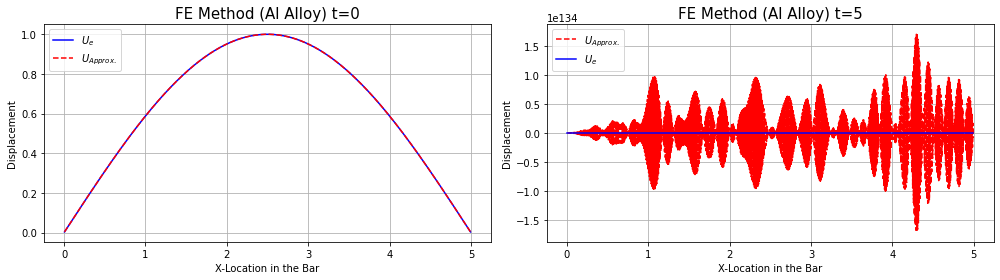

In [54]:
fig = plt.figure(figsize=(14, 4), tight_layout=True)
ax1 = fig.add_subplot(121)
ax1.plot(x_int, U1e_t0, 'b', label=r'$U_e$')
ax1.plot(x_int, U_FE_t0, 'r--', label=r'$U_{Approx.}$')
ax1.set_xlabel('X-Location in the Bar')
ax1.set_ylabel('Displacement')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.grid()
ax1.set_title('FE Method (Al Alloy) t=0', size=15)
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(122)
ax2.plot(x_int, U_FE_t5, 'r--', label=r'$U_{Approx.}$')
ax2.plot(x_int, U1e_t5, 'b', label=r'$U_e$')
ax2.set_xlabel('X-Location in the Bar')
ax2.set_ylabel('Displacement')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.grid()
ax2.set_title('FE Method (Al Alloy) t=5', size=15)
ax2.legend(loc='upper left');

## Testing Different Materials Elasticity

In [55]:
def traptest(E, rho, dt, n, U0):
    # Define dx
    dx = (b-a) / n
    
    ## Define A matrix
    ind = np.arange(0, 2*n-2, 1)
    ones = np.ones(n-1)

    ind_top_half_rows = ind[0:n-1]
    ind_top_half_cols = ind[n-1:]
    ind_bot_half_rows = ind[n-1:]
    ind_bot_half_cols = ind[0:n-1]

    # Add -2 diagonal
    neg2s = -2*ones
    A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add bottom 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top of matrix diagonal
    coef = rho*dx**2/E
    coefs = coef*ones
    A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Multiply A by the coefficient outside the matrix
    A = A*(E/(rho*dx**2))
    
    # Define I matrix
    I = np.eye(2*n-2)
    
    # Define timesteps
    t_step = int(T/dt) + 1
    times = np.linspace(0, T, t_step)
    
    # Define interpolation points
    x_interp = np.linspace(a, b, n+1)
    
    # Define interpolation points removing the boundaries
    x_interp_cut = x_interp[1:-1]
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    # Define left hand side of system
    LHS = I - (dt/2)*A
    
    # Step through time and solve for u_k to build u-vector
    for i in range(len(times)-1):
        RHS = U[i] + (dt/2) * (A @ U[i])
        U[i+1] = spsolve(LHS, RHS)
    
    # Cut U to only give displacements
    U = U[: , 0:n-1]
    
    return U

In [285]:
T = 140
n = 10
x_int = np.linspace(a, b, n+1)[1:-1]
# 1st Mode
v0s = np.zeros(n-1)
u0s_1st = np.sin(np.pi/5*x_int)
U0_1st = np.concatenate((u0s_1st, v0s))

# All Displacements at each time step
Utest = traptest(2.5, 490, 0.01, n, U0_1st) 

C:\Anaconda\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


## Visual Test

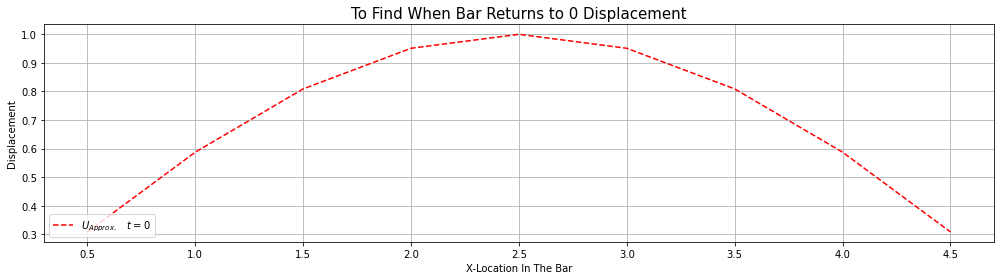

In [286]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 4), tight_layout=True)
ax1 = fig.add_subplot(111)
ax1.plot(x_int, Utest[-1], 'r--', label=r'$U_{Approx.} \quad t=0$')
ax1.set_xlabel('X-Location In The Bar')
ax1.set_ylabel('Displacement')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.grid()
ax1.set_title('To Find When Bar Returns to 0 Displacement', size=15) # Trapezoidal Method (Al Alloy)
ax1.legend(loc='lower left');

## Period Time Results

1) Aluminum Alloy 62s

2) Brass 93s

3) Copper 86s

4) Lead 253s

5) Steel 61s

6) Glass 58s

7) Granite 102s

8) Limestone 64s

9) Perspex 140s

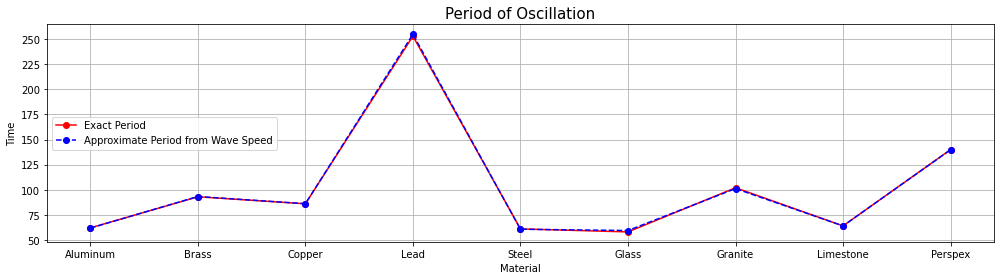

In [332]:
periods = [62, 93, 86, 253, 61, 58, 102, 64, 140]
cs = [5092, 3383, 3662, 1244, 5189, 5300, 3120, 4920, 2260]
Material_data = ['Aluminum', 'Brass', 'Copper', 'Lead', 'Steel', 'Glass', 'Granite', 'Limestone', 'Perspex']

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 4), tight_layout=True)
ax1 = fig.add_subplot(111)
ax1.plot(Material_data, periods, 'ro-', label='Exact Period')
ax1.plot(Material_data, 328559*np.array(cs)**-1.005, 'bo--', label='Approximate Period from Wave Speed')
ax1.set_xlabel('Material')
ax1.set_ylabel('Time')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xticks(np.arange(9), Material_data)
ax1.grid()
ax1.set_title('Period of Oscillation', size=15) # Trapezoidal Method (Al Alloy)
ax1.legend(loc='center left');

## Temporal Convergence

## Spacial Convergence